# LGBM Inference

In [1]:
import pandas as pd
import os
import random
import math
from tqdm import tqdm
import numpy as np
import time

import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import torch

## 데이터 로드

In [2]:
# 성능 제일 좋았음 07 서브미션

# train = pd.read_csv("/opt/ml/input/data/train_dataset/cv_train_data_FE.csv")
# valid = pd.read_csv("/opt/ml/input/data/train_dataset/cv_valid_data_FE.csv")
# test = pd.read_csv('/opt/ml/input/data/train_dataset/test_data_FE.csv')

In [3]:
# 성능 좀 떨어졌음 새로 만든 것 - 델타 새로하고, 테스트셋 조인 새로함

# train = pd.read_csv('/opt/ml/input/data/train_dataset/cv_new_train.csv')
# valid = pd.read_csv("/opt/ml/input/data/train_dataset/cv_new_valid.csv")
# test = pd.read_csv('/opt/ml/input/data/train_dataset/new_test.csv')

In [4]:
# 성능 제일 좋았던 것에서 델타 새로하고 상대누적값 추가 - 5천 돌렸을때 가장 높은 성능

train = pd.read_csv('/opt/ml/input/data/train_dataset/cv_train_data_FE_modify_FE_relative_log.csv')
valid = pd.read_csv("/opt/ml/input/data/train_dataset/cv_valid_data_FE_modify_FE_relative_log.csv")
test = pd.read_csv('/opt/ml/input/data/train_dataset/test_data_FE_modify_FE_relative_log.csv')

In [5]:
train

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,hour,dow,elapsed,grade,...,tag_delta,test_delta,assess_delta,left_asymptote,elo_prob,cum_correct,prior_relative_assess_ac_sum,prior_relative_answer_ac_sum,prior_relative_tag_ac_sum,prior_relative_test_ac_sum
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0,1,0.000000,6,...,0.000000,0.000000,0.000000,0,0.979350,1.00,0.000000,0.000000,0.000000,0.000000
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,0,1,1.386294,6,...,0.047218,0.057500,0.020000,0,0.970579,1.00,0.020000,0.292181,0.047218,0.057500
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,0,1,2.197225,6,...,0.089709,0.057500,0.040000,0,0.942168,1.00,0.060000,0.584362,0.136926,0.115000
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,0,1,2.079442,6,...,0.089709,0.057500,0.095000,0,0.972448,1.00,0.155000,0.876543,0.226635,0.172500
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,0,1,2.079442,6,...,0.089709,0.057500,0.035000,0,0.957230,1.00,0.190000,1.168725,0.316344,0.230000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008106,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,6,4,3.218876,3,...,0.143113,-0.670400,-0.600000,0,0.281925,0.25,-1.896000,-1.807287,0.628695,-1.681600
2008107,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,1,4,0.000000,4,...,0.143113,-0.670400,-0.456000,0,0.632742,0.00,-2.352000,-2.509109,0.771808,-2.352000
2008108,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,1,4,2.484907,4,...,0.143113,0.337045,0.340081,0,0.615929,1.00,-2.011919,-2.199696,0.914920,-2.014955
2008109,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,1,4,3.850148,4,...,0.115209,0.337045,0.364372,0,0.738609,1.00,-1.647547,-1.890284,1.030130,-1.677911


In [6]:
valid

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,hour,dow,elapsed,grade,...,tag_delta,test_delta,assess_delta,left_asymptote,elo_prob,cum_correct,prior_relative_assess_ac_sum,prior_relative_answer_ac_sum,prior_relative_tag_ac_sum,prior_relative_test_ac_sum
0,24,A090001001,A090000001,1,2020-02-18 06:42:34,4697,6,1,0.000000,9,...,0.000000,0.000000,0.000000,0,0.335942,0.000000,0.000000,0.000000,0.000000,0.000000
1,24,A090001002,A090000001,0,2020-02-18 06:44:39,4697,6,1,4.836282,9,...,0.493976,0.427083,0.562500,0,0.461441,1.000000,0.562500,0.477573,0.493976,0.427083
2,24,A090001003,A090000001,1,2020-02-18 06:45:06,10174,6,1,3.332205,9,...,-0.506024,-0.572917,-0.604167,0,0.603227,0.500000,-0.041667,-0.044853,-0.012048,-0.145833
3,24,A090001004,A090000001,1,2020-02-18 06:47:03,78,6,1,4.770685,9,...,0.270833,0.427083,0.270833,0,0.402934,0.666667,0.229167,0.432720,0.258785,0.281250
4,24,A090001005,A090000001,1,2020-02-18 06:47:12,78,6,1,2.302585,9,...,0.351515,0.427083,0.500000,0,0.538015,0.750000,0.729167,0.910294,0.610300,0.708333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258470,7422,A030171001,A030000171,0,2020-10-23 07:12:59,1873,7,4,0.000000,3,...,0.413333,-0.825000,-0.875000,0,0.360392,0.000000,0.351190,0.588037,-1.001843,0.351190
258471,7422,A030171002,A030000171,0,2020-10-23 07:13:35,1873,7,4,3.610918,3,...,-0.586667,-0.552941,-0.529412,0,0.525547,0.000000,-0.178221,-0.117907,-1.588510,-0.201751
258472,7422,A030171003,A030000171,0,2020-10-23 07:13:37,1876,7,4,1.098612,3,...,0.413333,-0.552941,-0.647059,0,0.298510,0.000000,-0.825280,-0.823851,-1.175176,-0.754692
258473,7422,A030171004,A030000171,0,2020-10-23 07:13:38,1876,7,4,0.693147,3,...,-0.586667,-0.552941,-0.500000,0,0.564019,0.000000,-1.325280,-1.529795,-1.761843,-1.307633


In [7]:
test

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,hour,dow,elapsed,grade,...,answer_delta,tag_delta,test_delta,assess_delta,left_asymptote,elo_prob,prior_relative_assess_ac_sum,prior_relative_answer_ac_sum,prior_relative_tag_ac_sum,prior_relative_test_ac_sum
0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626,10,3,0.000000,5,...,0.000000,0.000000,0.000000,0.000000,0,0.752296,0.000000,0.000000,0.000000,0.000000
1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626,10,3,3.295837,5,...,0.337382,0.412903,0.526786,0.250000,0,0.416693,0.250000,0.337382,0.412903,0.526786
2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625,10,3,4.553877,5,...,0.337382,0.412903,0.526786,0.437500,0,0.281076,0.687500,0.674764,0.825806,1.053571
3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625,10,3,1.791759,5,...,-0.662618,-0.588517,-0.473214,-0.343750,0,0.382929,0.343750,0.012146,0.237290,0.580357
4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623,10,3,2.079442,5,...,-0.662618,-0.588517,-0.473214,-0.500000,0,0.166432,-0.156250,-0.650472,-0.351227,0.107143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260109,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832,23,2,0.000000,4,...,0.355276,0.136364,0.255208,0.125000,0,0.132075,-0.711993,0.908039,0.370093,-0.711993
260110,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832,23,2,2.944439,4,...,-0.644724,0.136364,-0.604762,-0.380952,0,0.410814,-1.092946,0.263315,0.506456,-1.316755
260111,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244,23,2,3.091042,4,...,0.355276,0.136364,0.395238,0.476190,0,0.621880,-0.616755,0.618591,0.642820,-0.921517
260112,7439,A040130004,A040000130,1,2020-10-14 23:09:31,8244,23,2,4.499810,4,...,0.355276,-0.776087,0.395238,0.238095,0,0.760312,-0.378660,0.973867,-0.133267,-0.526279


In [8]:
# 테스트셋 사용하기
test_for_train = test.loc[test.answerCode != -1]

In [9]:
# 컬럼 떨구고 합치기
train = train.drop(['cum_correct'], axis = 1)
valid = valid.drop(['cum_correct'], axis = 1)

train = pd.concat([train, test_for_train]).sort_values(by=['userID', 'Timestamp']).reset_index()
train = train.drop(['index'], axis = 1)

In [14]:
train

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,hour,dow,elapsed,grade,...,answer_delta,tag_delta,test_delta,assess_delta,left_asymptote,elo_prob,prior_relative_assess_ac_sum,prior_relative_answer_ac_sum,prior_relative_tag_ac_sum,prior_relative_test_ac_sum
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0,1,0.000000,6,...,0.000000,0.000000,0.000000,0.000000,0,0.979350,0.000000,0.000000,0.000000,0.000000
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,0,1,1.386294,6,...,0.292181,0.047218,0.057500,0.020000,0,0.970579,0.020000,0.292181,0.047218,0.057500
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,0,1,2.197225,6,...,0.292181,0.089709,0.057500,0.040000,0,0.942168,0.060000,0.584362,0.136926,0.115000
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,0,1,2.079442,6,...,0.292181,0.089709,0.057500,0.095000,0,0.972448,0.155000,0.876543,0.226635,0.172500
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,0,1,2.079442,6,...,0.292181,0.089709,0.057500,0.035000,0,0.957230,0.190000,1.168725,0.316344,0.230000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2267476,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,6,4,3.218876,3,...,-0.701822,0.143113,-0.670400,-0.600000,0,0.281925,-1.896000,-1.807287,0.628695,-1.681600
2267477,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,1,4,0.000000,4,...,-0.701822,0.143113,-0.670400,-0.456000,0,0.632742,-2.352000,-2.509109,0.771808,-2.352000
2267478,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,1,4,2.484907,4,...,0.309413,0.143113,0.337045,0.340081,0,0.615929,-2.011919,-2.199696,0.914920,-2.014955
2267479,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,1,4,3.850148,4,...,0.309413,0.115209,0.337045,0.364372,0,0.738609,-1.647547,-1.890284,1.030130,-1.677911


In [15]:
# LEAVE LAST INTERACTION ONLY
test = test[test['userID'] != test['userID'].shift(-1)]
# DROP ANSWERCODE
test = test.drop(['answerCode'], axis=1)

In [16]:
train.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'hour', 'dow', 'elapsed', 'grade', 'mid',
       'problem_number', 'test_mean', 'test_sum', 'tag_mean', 'tag_sum',
       'ass_mean', 'ass_sum', 'prb_mean', 'prb_sum', 'hour_mean', 'hour_sum',
       'dow_mean', 'dow_sum', 'tag_elp', 'tag_elp_o', 'tag_elp_x', 'ass_elp',
       'ass_elp_o', 'ass_elp_x', 'prb_elp', 'prb_elp_o', 'prb_elp_x',
       'user_correct_answer', 'user_total_answer', 'user_acc', 'Grade_o',
       'GradeCount', 'GradeAcc', 'GradeElp', 'GradeMElp', 'problem_count',
       'tag_count', 'RepeatedTime', 'prior_KnowledgeTag_frequency',
       'problem_position', 'solve_order', 'retest', 'solved_disorder',
       'last_problem', 'answer_delta', 'tag_delta', 'test_delta',
       'assess_delta', 'left_asymptote', 'elo_prob',
       'prior_relative_assess_ac_sum', 'prior_relative_answer_ac_sum',
       'prior_relative_tag_ac_sum', 'prior_relative_test_ac_sum'],
      dtype='obje

In [17]:
test

,userID,assessmentItemID,testId,Timestamp,KnowledgeTag,hour,dow,elapsed,grade,mid,...,answer_delta,tag_delta,test_delta,assess_delta,left_asymptote,elo_prob,prior_relative_assess_ac_sum,prior_relative_answer_ac_sum,prior_relative_tag_ac_sum,prior_relative_test_ac_sum
1035,3,A050133008,A050000133,2020-10-26 13:13:57,5289,13,0,3.850148,5,133,...,-0.662618,-0.542662,-0.661765,-0.235294,0,0.445639,23.225504,18.283621,17.058226,23.416681
1706,4,A070146008,A070000146,2020-12-27 02:47:54,9080,2,6,3.178054,7,146,...,0.484309,0.434307,0.259615,0.076923,0,0.136933,63.056800,67.278898,74.851625,63.643339
3023,13,A070111008,A070000111,2020-12-27 04:35:09,9660,4,6,2.197225,7,111,...,0.484309,0.553247,0.582143,0.571429,0,0.150526,54.612535,54.126292,42.014788,54.744678
4283,17,A090064006,A090000064,2020-10-30 05:48:37,2611,5,4,4.330733,9,64,...,0.501508,0.485714,0.375000,0.500000,0,0.520654,239.247278,250.261781,235.697179,239.622278
4670,26,A060135007,A060000135,2020-10-23 11:44:18,1422,11,4,2.890372,6,135,...,-0.733989,-0.602767,-0.678571,-0.678571,0,0.327865,19.732816,9.534262,14.623528,20.089959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260052,7395,A040122005,A040000122,2020-09-08 02:05:20,10615,2,1,1.098612,4,122,...,-0.644724,-0.747212,-0.753846,-0.769231,0,0.058178,-7.814061,-6.929145,-5.280860,-7.419189
260067,7404,A030111005,A030000111,2020-10-13 09:49:18,7636,9,1,4.682131,3,111,...,0.302917,0.285372,0.133333,0.055556,0,0.525786,-2.930556,-2.695926,-4.803973,-2.925000
260082,7416,A050193004,A050000193,2020-10-04 02:44:41,10402,2,6,3.218876,5,193,...,-0.662618,-0.821978,-0.750000,-0.400000,0,0.333741,-1.548571,-1.337640,-0.185795,-1.558571
260097,7417,A050193004,A050000193,2020-09-06 13:09:15,10402,13,6,3.091042,5,193,...,-0.662618,-0.834661,-0.750000,-0.400000,0,0.164310,-7.920978,-8.835997,-1.127414,-7.930978


## 카테고리 피쳐 라벨링

In [18]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

ordinal_feats = ['grade']
label_feats = ['problem_number','hour','dow','solved_disorder','KnowledgeTag','testId','retest']
        
# 'problem_number','grade', 'testId','KnowledgeTag','problem_count','type_count','solved_disorder'

for c in ordinal_feats :
    X = train[c].values.reshape(-1,1)
    enc = OrdinalEncoder()
    enc.fit(X)
    X = enc.transform(X)
    train[c] = X

    X = valid[c].values.reshape(-1,1)
    X = enc.transform(X)
    valid[c] = X
    
    X = test[c].values.reshape(-1,1)
    X = enc.transform(X)
    test[c] = X
    
for c in label_feats :
    X = train[c].values.reshape(-1,1)
    enc = LabelEncoder()
    enc.fit(X)
    X = enc.transform(X)
    train[c] = X

    X = valid[c].values.reshape(-1,1)
    X = enc.transform(X)
    valid[c] = X
    
    X = test[c].values.reshape(-1,1)
    X = enc.transform(X)
    test[c] = X

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [19]:
# 사용할 Feature 설정

FEATS = [
    'last_problem', 'elapsed', 'grade', 'prior_KnowledgeTag_frequency','KnowledgeTag','testId','retest','hour','dow',"hour_mean", 'hour_sum', "dow_mean", 'dow_sum',
       'problem_number', 'test_mean', 'test_sum', 'tag_mean', 'tag_sum', 'elo_prob',
    
        'tag_delta', 'answer_delta', 'test_delta', 'assess_delta',
    
        'prior_relative_assess_ac_sum', 'prior_relative_answer_ac_sum',
       'prior_relative_tag_ac_sum', 'prior_relative_test_ac_sum',
    
       'ass_mean', 'ass_sum', 'prb_mean', 'prb_sum', 'tag_elp', 'tag_elp_o',
       'tag_elp_x', 'ass_elp', 'ass_elp_o', 'ass_elp_x', 'prb_elp',
       'prb_elp_o', 'prb_elp_x', 'user_correct_answer', 'user_total_answer',
       'user_acc', 'Grade_o', 'GradeCount', 'GradeAcc', 'GradeElp',
       'GradeMElp', 'problem_count', 'tag_count', 'RepeatedTime',
       'problem_position', 'solve_order', 'solved_disorder'
]


In [20]:
# X, y 값 분리
y_train = train['answerCode']
train = train.drop(['answerCode'], axis=1)

y_valid = valid['answerCode']
valid = valid.drop(['answerCode'], axis=1)

In [21]:
lgb_train = lgb.Dataset(train[FEATS], y_train)
lgb_valid = lgb.Dataset(valid[FEATS], y_valid)

## 4. 훈련 및 검증

In [36]:
'''
    original
'''
model = lgb.train(
                    {'objective': 'binary','metric':'auc', 'boosting' : 'dart', 'learning_rate':0.05},
#                     {'objective': 'binary','metric':'auc','boosting':'dart',
#                      'learning_rate':0.05,'max_depth':15,'feature_fraction':0.8},
                    lgb_train,
                    valid_sets=[lgb_train, lgb_valid],
                    verbose_eval=100,
                    num_boost_round=8000,
                    early_stopping_rounds=200
                )

model.save_model('/opt/ml/output/lgbm_train_with_test_8000.txt')

preds = model.predict(valid[FEATS])
acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_valid, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

[LightGBM] [Info] Number of positive: 1484550, number of negative: 782931
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.185787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8663
[LightGBM] [Info] Number of data points in the train set: 2267481, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654713 -> initscore=0.639822
[LightGBM] [Info] Start training from score 0.639822


/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:183: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	training's auc: 0.846718	valid_1's auc: 0.843393
[200]	training's auc: 0.850491	valid_1's auc: 0.84693
[300]	training's auc: 0.853182	valid_1's auc: 0.849536
[400]	training's auc: 0.854706	valid_1's auc: 0.851064
[500]	training's auc: 0.856183	valid_1's auc: 0.852477
[600]	training's auc: 0.856708	valid_1's auc: 0.852884
[700]	training's auc: 0.857256	valid_1's auc: 0.853324
[800]	training's auc: 0.857741	valid_1's auc: 0.853692
[900]	training's auc: 0.858301	valid_1's auc: 0.854096
[1000]	training's auc: 0.858676	valid_1's auc: 0.85434
[1100]	training's auc: 0.859055	valid_1's auc: 0.854618
[1200]	training's auc: 0.859263	valid_1's auc: 0.854736
[1300]	training's auc: 0.859584	valid_1's auc: 0.854967
[1400]	training's auc: 0.85999	valid_1's auc: 0.855214
[1500]	training's auc: 0.860223	valid_1's auc: 0.855371
[1600]	training's auc: 0.860496	valid_1's auc: 0.855528
[1700]	training's auc: 0.860845	valid_1's auc: 0.855701
[1800]	training's auc: 0.861157	valid_1's auc: 0.855881
[190

In [61]:
# 추가 학습
lgb_new_train = lgb.Dataset(train[FEATS], y_train, free_raw_data = False)
lgb_new_valid = lgb.Dataset(valid[FEATS], y_valid, free_raw_data = False)

train_again = lgb.train(
                    {'objective': 'binary','metric':'auc', 'boosting' : 'dart', 'learning_rate':0.05},
                    lgb_new_train,
                    valid_sets=[lgb_new_train, lgb_new_valid],
                    verbose_eval=100,
                    num_boost_round=2000,
                    early_stopping_rounds=200,
                    keep_training_booster = True,
                    init_model=model)

train_again.save_model('/opt/ml/output/lgbm_train_with_test_10000.txt')
preds = train_again.predict(valid[FEATS])
acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_valid, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

[LightGBM] [Info] Number of positive: 1484550, number of negative: 782931
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.216026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8663
[LightGBM] [Info] Number of data points in the train set: 2267481, number of used features: 54


/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:183: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[8100]	training's auc: 0.873998	valid_1's auc: 0.858234
[8200]	training's auc: 0.874113	valid_1's auc: 0.858245
[8300]	training's auc: 0.874264	valid_1's auc: 0.85825
[8400]	training's auc: 0.874414	valid_1's auc: 0.858251
[8500]	training's auc: 0.874581	valid_1's auc: 0.858253
[8600]	training's auc: 0.874677	valid_1's auc: 0.858261
[8700]	training's auc: 0.874826	valid_1's auc: 0.85827
[8800]	training's auc: 0.874949	valid_1's auc: 0.858273
[8900]	training's auc: 0.875095	valid_1's auc: 0.858282
[9000]	training's auc: 0.875212	valid_1's auc: 0.858283
[9100]	training's auc: 0.87536	valid_1's auc: 0.858286
[9200]	training's auc: 0.875451	valid_1's auc: 0.858293
[9300]	training's auc: 0.875572	valid_1's auc: 0.858303
[9400]	training's auc: 0.875736	valid_1's auc: 0.858303
[9500]	training's auc: 0.875831	valid_1's auc: 0.858317
[9600]	training's auc: 0.875985	valid_1's auc: 0.85832
[9700]	training's auc: 0.876139	valid_1's auc: 0.858327
[9800]	training's auc: 0.87628	valid_1's auc: 0.8583

In [37]:
## 불러올때 이렇게 불러와야된다 ~!!!
#model = lgb.Booster(model_file='/opt/ml/output/lgbm_train_with_test.txt')

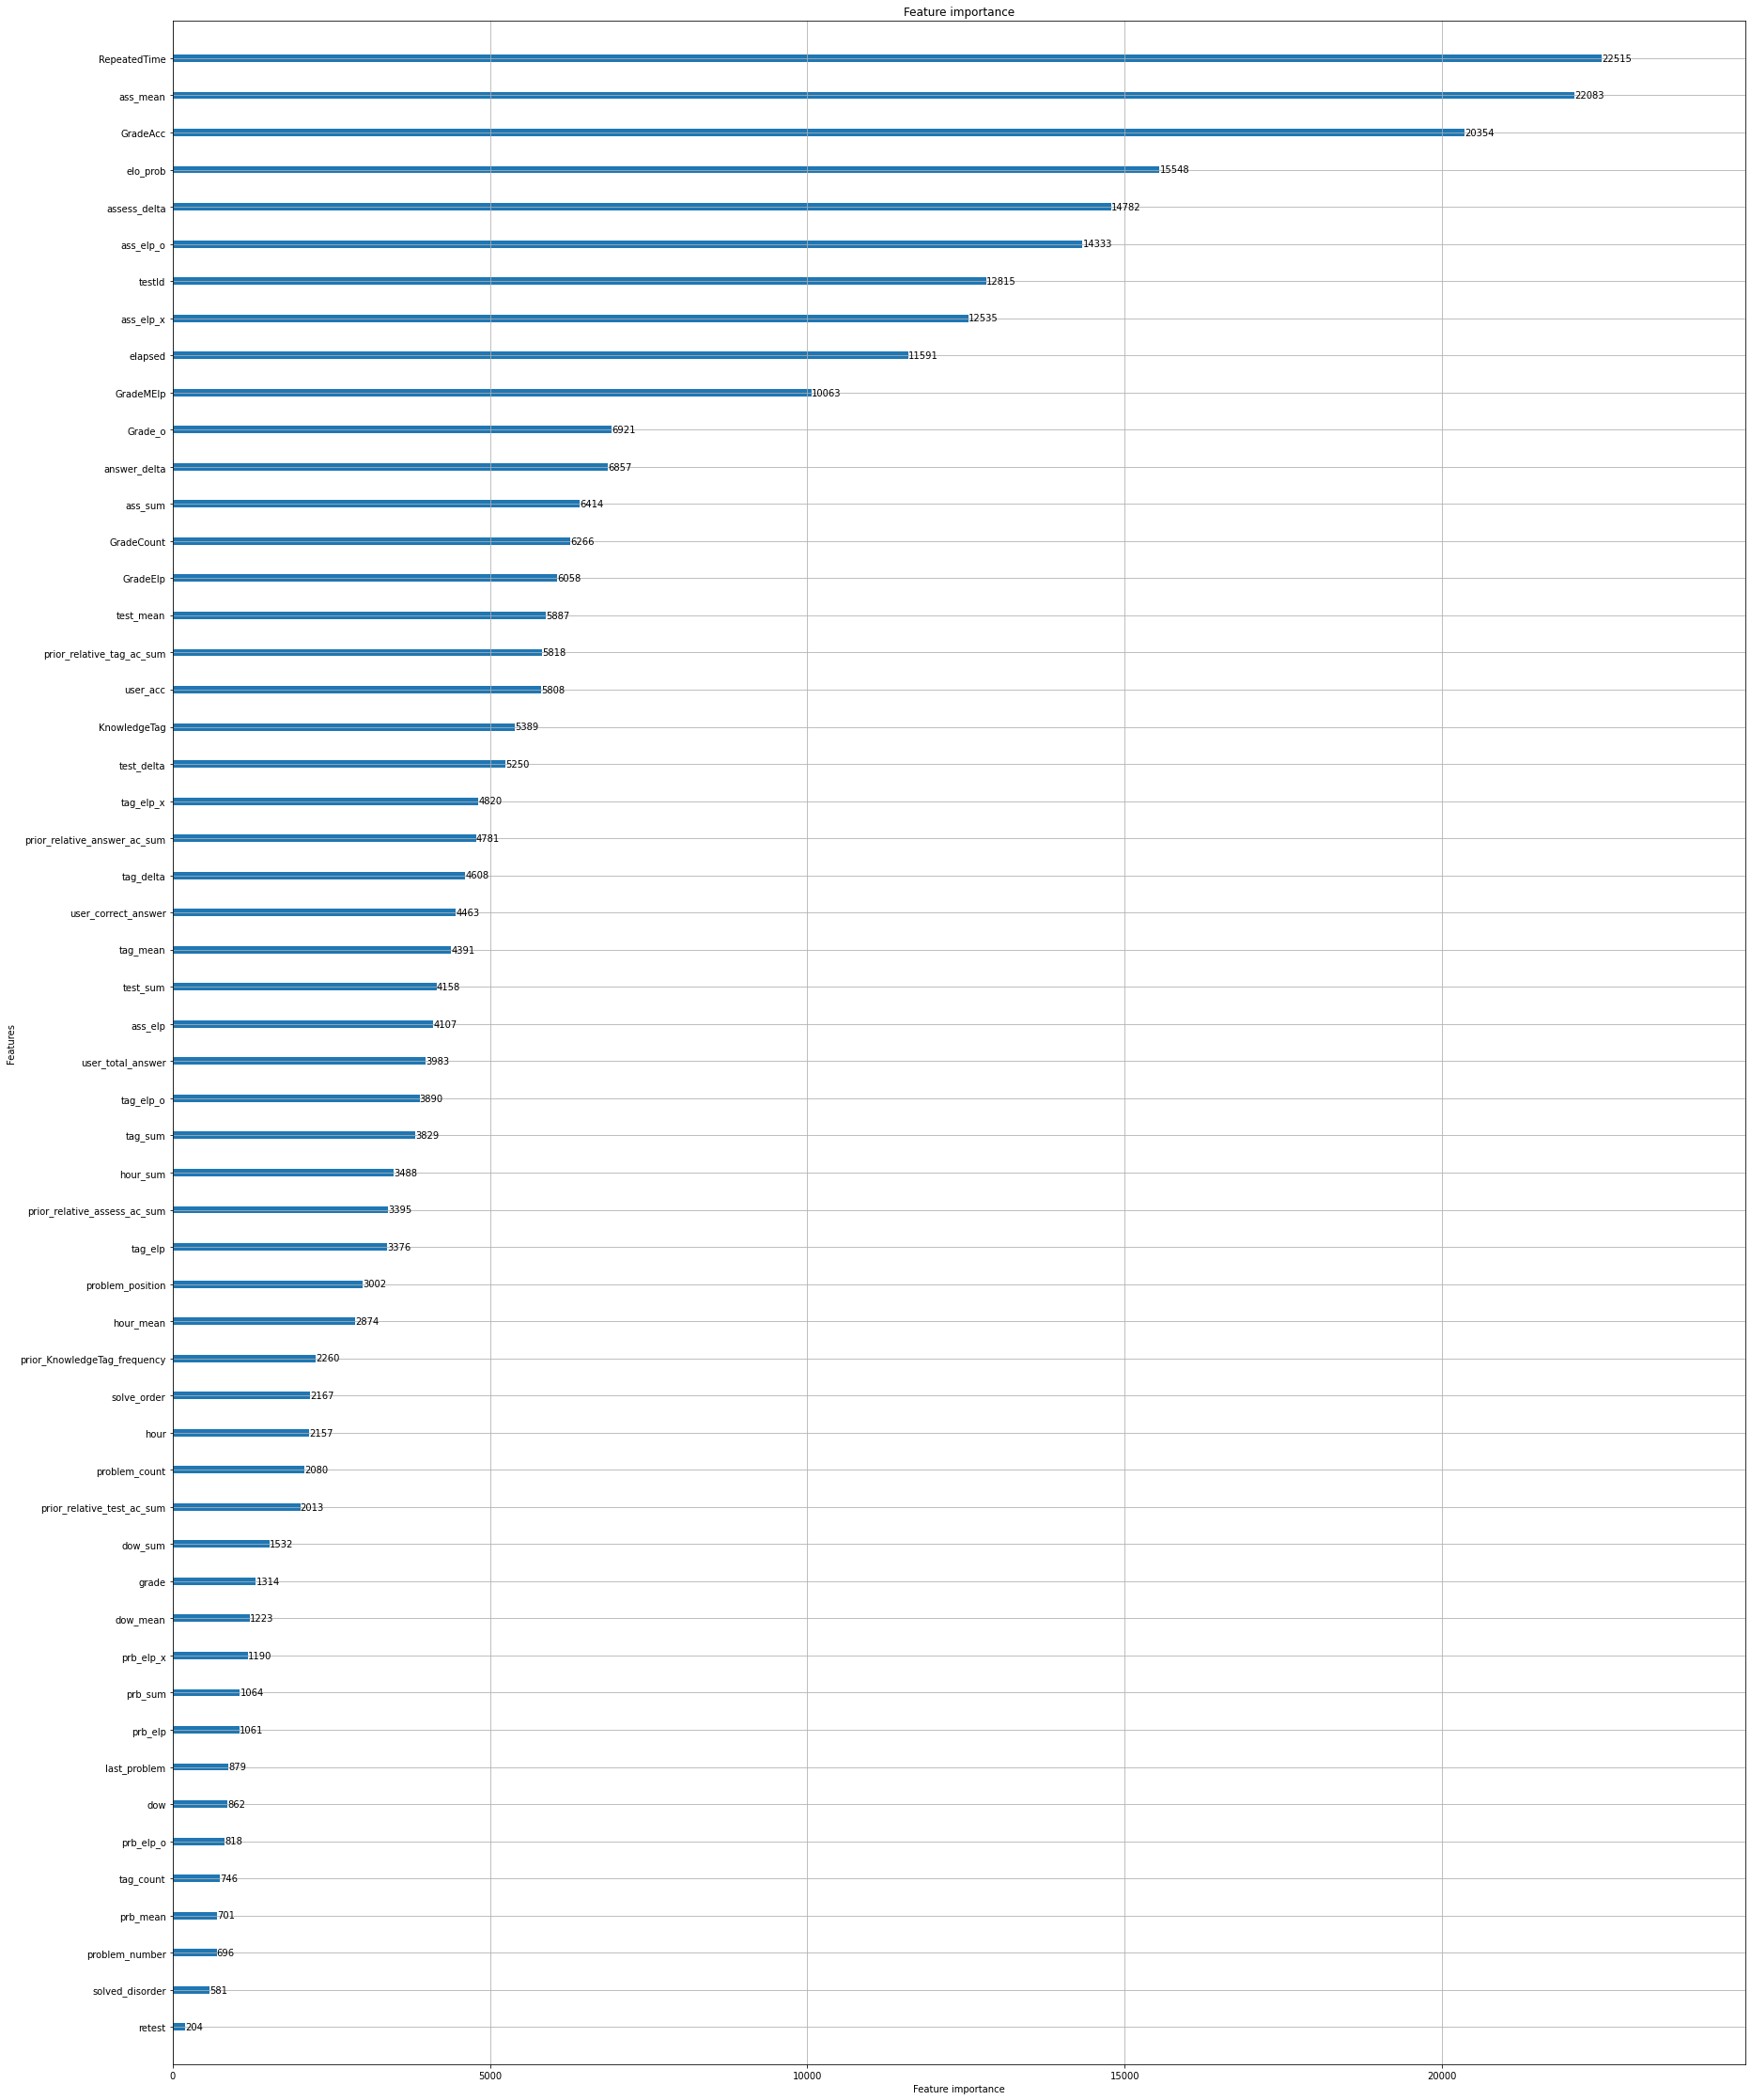

In [62]:
# 이어서한 모델 피쳐임포턴스
ax = lgb.plot_importance(train_again)
fig = ax.figure
fig.set_size_inches(30, 40)

In [63]:
# MAKE PREDICTION
total_preds = train_again.predict(test[FEATS])

output_dir = '/opt/ml/output/'
write_path = os.path.join(output_dir, "LGBM_all_modified_features_with_testset_10000 (dart).csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)    
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : /opt/ml/output/LGBM_all_modified_features_with_testset_10000 (dart).csv


In [64]:
total_preds

array([5.54303419e-01, 7.01395806e-01, 2.27341491e-01, 7.61546355e-01,
       2.82722434e-01, 8.98651752e-01, 6.79234391e-02, 2.28598283e-01,
       1.81389530e-01, 4.40004378e-01, 3.90311759e-01, 3.61852046e-01,
       9.39527822e-01, 1.04518810e-01, 5.20343501e-01, 9.59078107e-01,
       1.99516443e-01, 8.63311433e-01, 9.28783019e-01, 2.22647408e-01,
       9.51917617e-01, 6.00310136e-01, 6.63247624e-01, 1.47791465e-01,
       2.26456411e-01, 7.04247904e-01, 9.24523713e-01, 9.23841908e-01,
       5.13519121e-01, 7.93257482e-01, 7.55315228e-01, 6.53414474e-01,
       8.37360999e-01, 1.17845177e-01, 8.88905208e-01, 9.06456638e-01,
       1.61851381e-01, 6.26833241e-01, 3.09239716e-01, 1.48950630e-01,
       5.84010764e-01, 1.22555258e-01, 1.92287275e-01, 3.23573890e-01,
       6.41286744e-01, 8.46870483e-01, 5.72397341e-01, 2.37048702e-01,
       9.50612339e-01, 6.70080612e-01, 7.34151437e-01, 2.53293928e-01,
       3.48970158e-01, 1.13688073e-01, 3.76625982e-01, 7.31101324e-01,
      

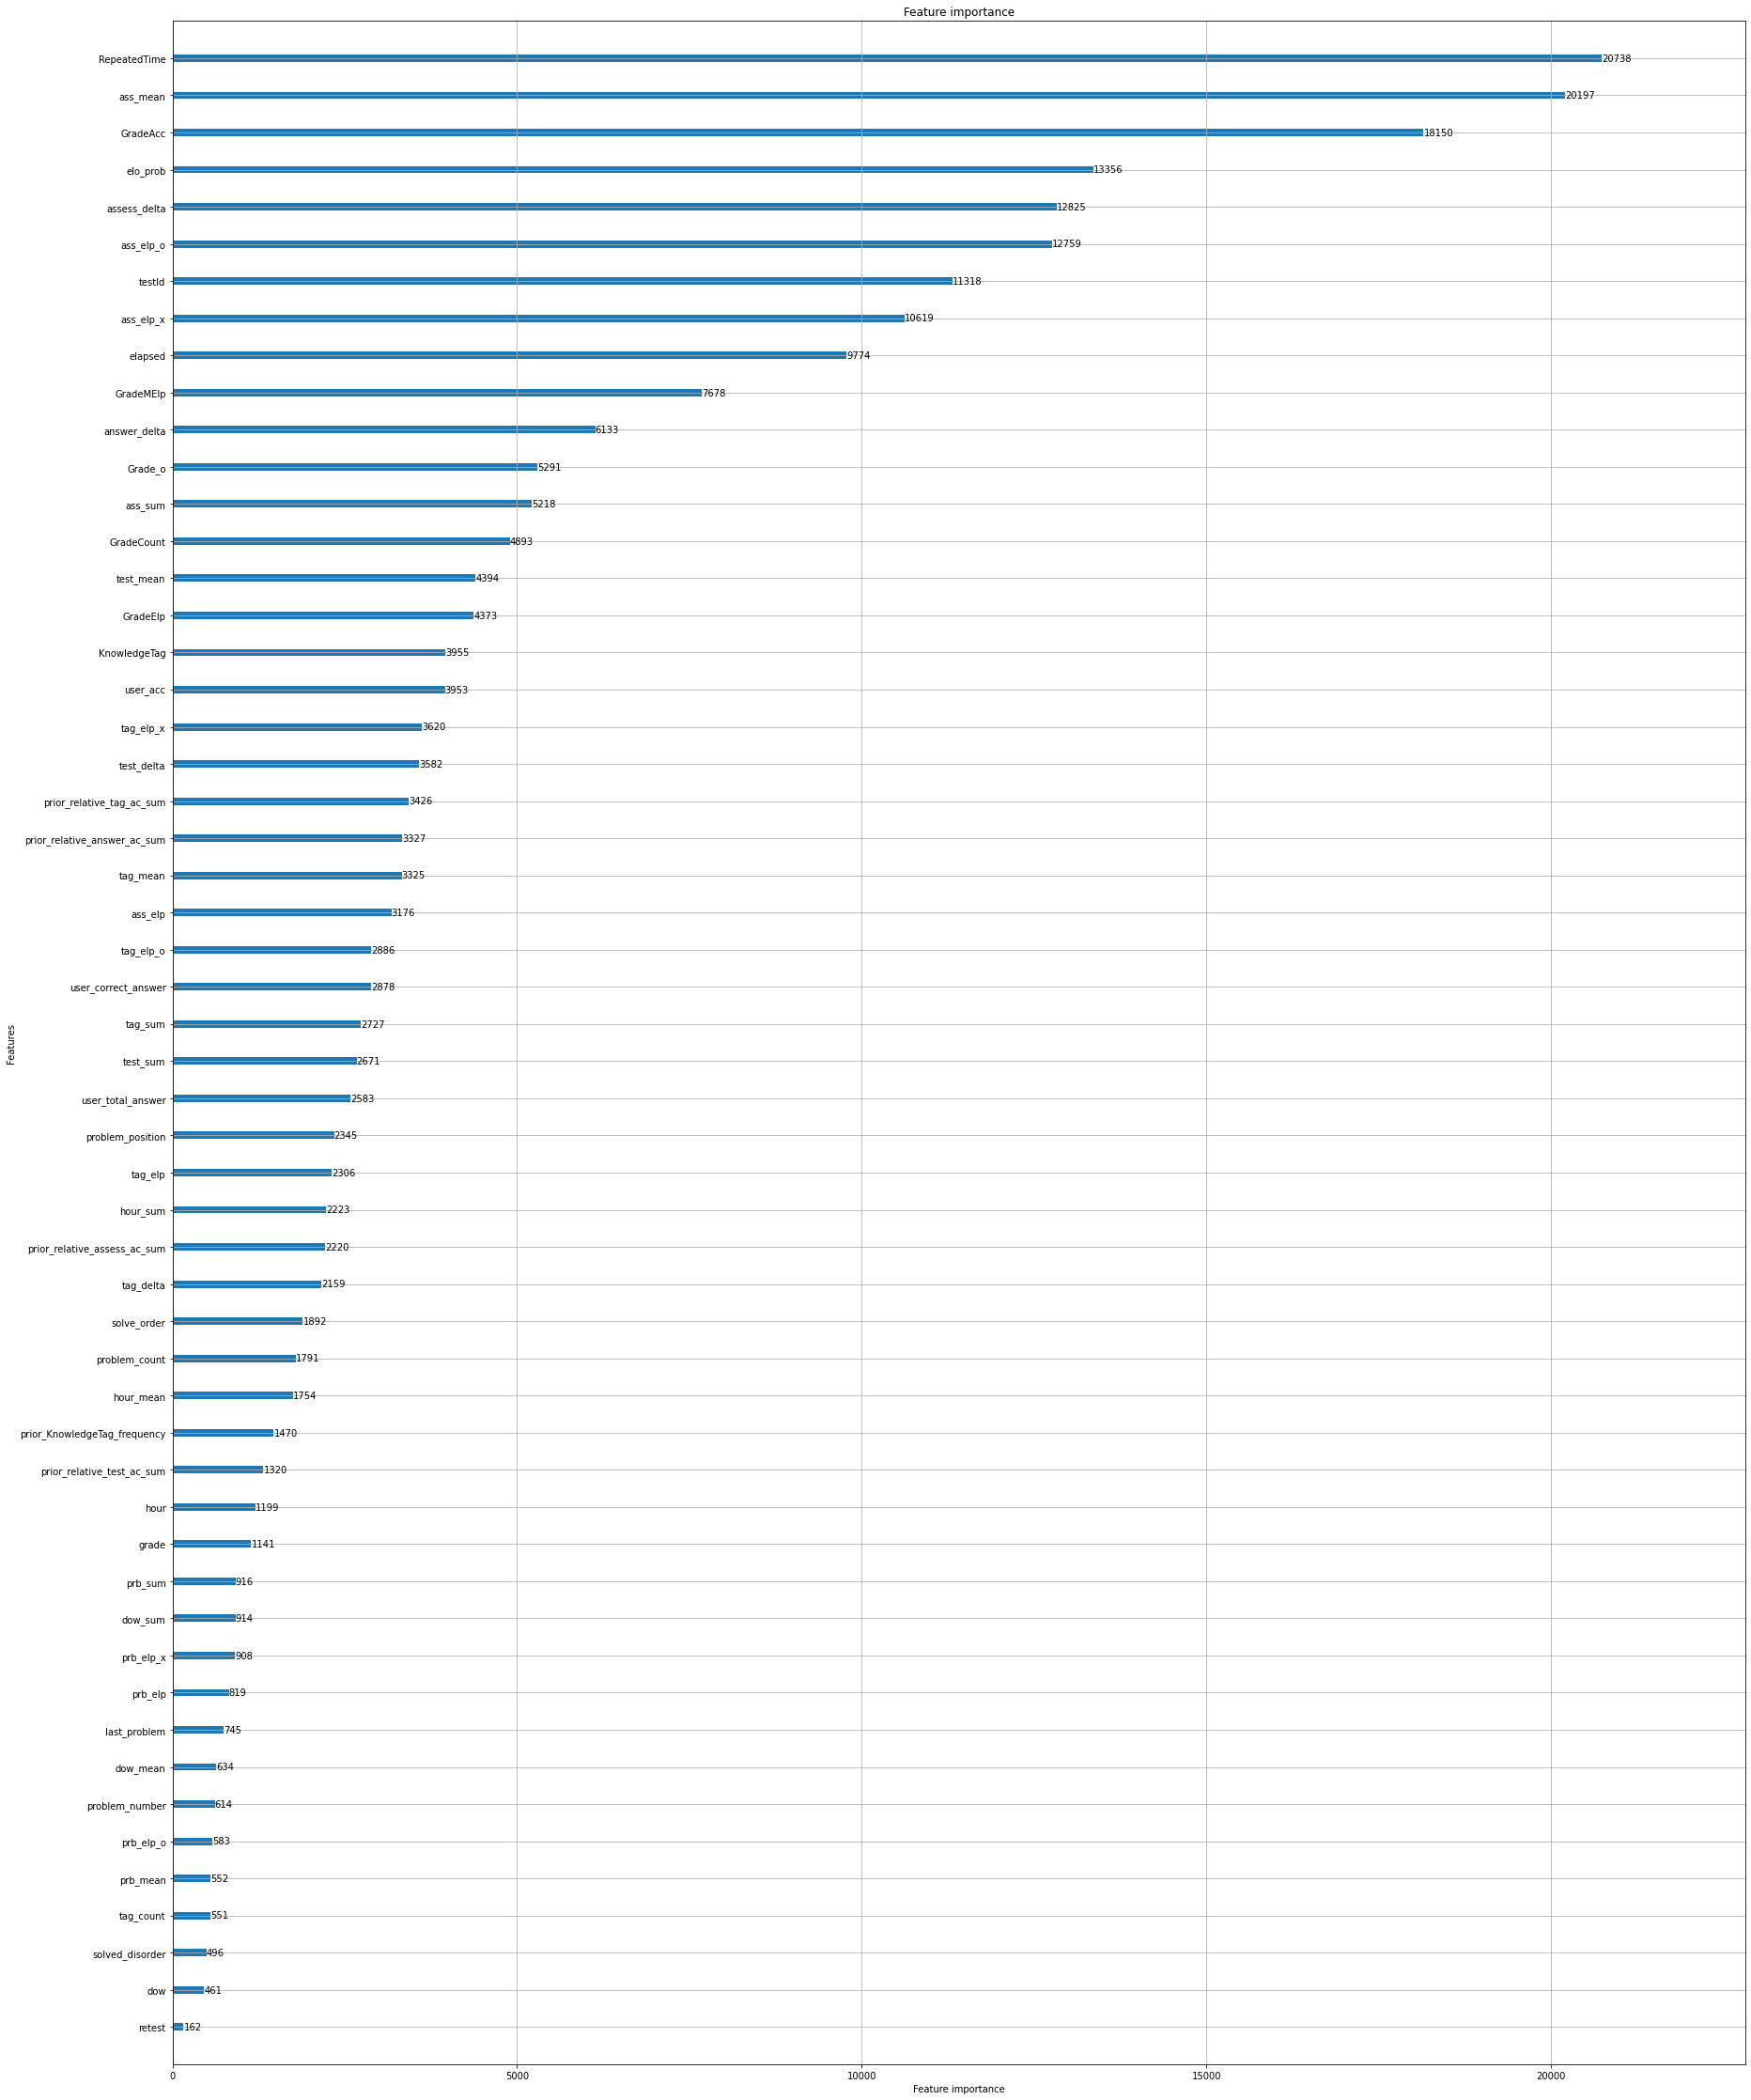

In [38]:
# Feature Importance 파악
import matplotlib.pyplot as plt
ax = lgb.plot_importance(model)
fig = ax.figure
fig.set_size_inches(30, 40)

## Inference

In [39]:
# MAKE PREDICTION
total_preds = model.predict(test[FEATS])

In [40]:
# SAVE OUTPUT
output_dir = '/opt/ml/output/'
write_path = os.path.join(output_dir, "LGBM_all_modified_features_with_testset_8000 (dart).csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)    
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : /opt/ml/output/LGBM_all_modified_features_with_testset_8000 (dart).csv


In [41]:
total_preds

array([5.60784046e-01, 6.92995383e-01, 2.24168461e-01, 7.36882547e-01,
       2.91233088e-01, 8.96964164e-01, 7.40620190e-02, 2.12063083e-01,
       1.85751346e-01, 4.30661676e-01, 3.91270729e-01, 3.95127221e-01,
       9.28980059e-01, 1.08104564e-01, 5.39608505e-01, 9.55867355e-01,
       1.96777702e-01, 8.59948382e-01, 9.20937783e-01, 2.27994885e-01,
       9.48335568e-01, 5.96596404e-01, 6.27974837e-01, 1.54653973e-01,
       2.37348016e-01, 7.08905855e-01, 9.23041699e-01, 9.22815676e-01,
       5.20340058e-01, 7.73763796e-01, 7.64808410e-01, 6.55797859e-01,
       8.36621170e-01, 1.24327108e-01, 8.83945746e-01, 8.86006310e-01,
       1.63291021e-01, 6.13295046e-01, 3.23690078e-01, 1.39946245e-01,
       5.85951928e-01, 1.35760976e-01, 1.95564459e-01, 3.24689043e-01,
       6.45472023e-01, 8.39348713e-01, 5.84145804e-01, 2.36554712e-01,
       9.49842653e-01, 6.63590188e-01, 7.18836039e-01, 2.56632670e-01,
       3.50818815e-01, 1.14124500e-01, 3.89056604e-01, 7.30963348e-01,
      